In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from pulse_utility import *

In [2]:
# Variables to be swept
ampX = Variable('amp', 1, unit='')
delayRamsey = Variable('delay', 50, unit='')

# pulse setting
px2 = {'Mode': 'Gaussian_sc',
       'RotAxis': 'X', 'Type': 'px',
       'GateTime': 48, 'Sigma': 12,
       'Xscale': ampX,
       'Yscale': 0}

pulse_args_read = {'Mode':'FTG', 'RotAxis':0,
                   'GateTime':320, 'Sigma': 4, 'Xscale': .2}

In [3]:
# Generate instance of instructions 
pi2pulse = pulseshape(px2, 1)
vz = phase_shift(np.pi/2)
buff = buffer(10,1)
buff_last = buffer(50,1)
delay = buffer(delayRamsey,1)
read = pulseshape(pulse_args_read, 1)
barr = barrier()

In [4]:
# Generate channel instance. 
# Here, we assume IQ mixing, so each channel generates two waveforms for I and Q channels.
ch0 = channel_awg(frequency=25e6, name='qubit',
                  phase_offset=[0, 0], amplitude_scaling=1,
                  dc_offset=0, dt=1, mode='IQ', ignore_phase=False)

# "ignore_phase" is used to avoid phase rotation in IQ-plane for the readout signal.
ch1 = channel_awg(frequency=25e6, name='cavity',
                  phase_offset=[0, 0], amplitude_scaling=1.1,
                  dc_offset=0, dt=1, mode='IQ', ignore_phase=True)

In [5]:
"""
Prepare sequence for an experiment.
sequence is a list of tuple.
Each tuple structure should be ([channle object], instruction object).
The barrier instruction synchronizes the pulse waveform between the channels.
For the barrier instruction, you can apply multi channel object like ([ch0, ch1, ch2,...], barr).
"""
seq = [([ch0], pi2pulse), ([ch0], delay), ([ch0], vz), ([ch0], pi2pulse)]
seq += [([ch0, ch1], barr), ([ch1], buff), ([ch1], read), ([ch0], buff_last), ([ch1], buff_last)]
# seq += [([ch0, ch1], barr), ([ch0], pi2pulse), ([ch0], buff_last), ([ch1], buff_last)]

In [6]:
# Generate teh pulse schedule instance
# Using "align_right" you can align pulse sequence left or right
# "length_max" must be longer than the total length of sequence.
ramsey = schedule(seq, length_max=700, align_right=True)

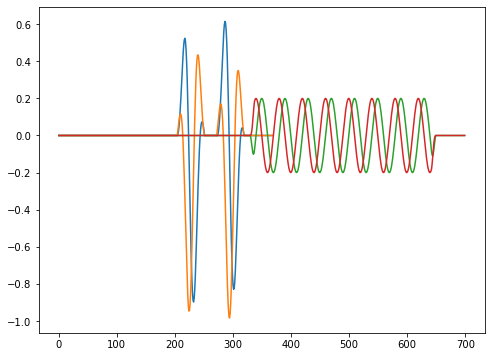

In [7]:
# Generate the IQ-waveform for qubit and cavity
channels = ramsey.channel_list

delayRamsey.set_value(20)
fig, axes = plt.subplots(1,1, figsize=[8,6])
wfs = ramsey.get_waveform()
for ret in wfs.keys():
    i,q = wfs[ret]
    axes.plot(i)
    axes.plot(q)

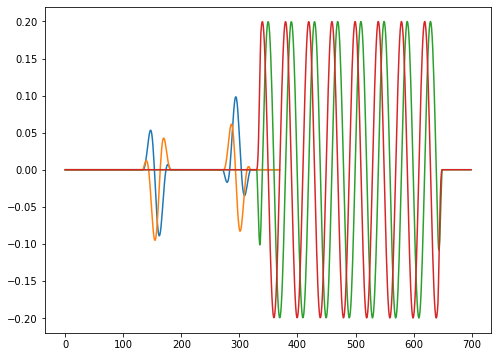

In [8]:
# Demo of updating variables
delayRamsey.set_value(90)
ampX.set_value(0.1)

fig, axes = plt.subplots(1,1, figsize=[8,6])
wfs = ramsey.get_waveform()
for ret in wfs.keys():
    i,q = wfs[ret]
    axes.plot(i)
    axes.plot(q)